## Import packages

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from fancyimpute import KNN
from fancyimpute import IterativeImputer
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import itertools

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.tree import export_graphviz
from subprocess import check_call
import pydot

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  
from sklearn.preprocessing import binarize
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## Import DataFrame

In [9]:
raw_df = pd.read_csv('nhanes.csv')

# lower column names
raw_df.columns = [col.lower() for col in raw_df.columns]

## Clean DataFrame

In [10]:
# Physician Diabetes Dx
# 0 = No Dx; 1 = Yes Dx
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: np.nan if (x == 3)|(x == 7)|(x == 9) else x)
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: 0 if x == 2 else x)

# Sex
# 0 = Female; 1 = Male
raw_df['riagendr'] = raw_df['riagendr'].apply(lambda x: 0 if (x == 2) else x)

# Education
# HS and less = 0, less than college = 1, college or above = 2
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: np.nan if (x == 7)|(x == 9) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 0 if (x <= 3) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 1 if (x == 4) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 2 if (x == 5) else x)

# Citizenship
# 0 = No citizenship, 1 = Citizensip
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: np.nan if (x == 7)|(x == 9) else x)
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: 0 if x == 2 else x)

# Alcohol
# 1 = Yes, 0 = No
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: np.nan if (x == 9) else x)
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: 0 if (x == 2) else x)

# Veteran
# 1 = No, 0 = Yes
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: np.nan if (x == 7) else x)
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: 0 if (x == 2) else x)

# Smoke
# 1 = Yes, 0 = No
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: np.nan if (x == 7)|(x == 9) else x)
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: 0 if x == 2 else x)

# Moderate Physical Activity
# 1 = Yes, 0 = No
raw_df['paq620'] = raw_df['paq620'].apply(lambda x: np.nan if (x == 7)|(x == 9) else x)
raw_df['paq620'] = raw_df['paq620'].apply(lambda x: 0 if x == 2 else x)

# Diabetes - Clean after imputing missing values to appropriately categorize 0, 1, 2
df_y = raw_df['lbxgh']

## Predictors
predictors = [
    ('age','ridageyr'),
    ('bmi','bmxbmi'),
    ('bun', 'lbxsbu'),
    ('race','ridreth3'),
    ('education', 'dmdeduc2'),
    ('sex', 'riagendr'),
    ('diabetes_dx', 'diq010'),
    ('citizen', 'dmdcitzn'),
    ('alcohol', 'alq101'),
    ('veteran', 'dmqmiliz'),
    ('smoke', 'smq020'),
    ('systolicBP', 'bpxsy2'),
    ('ast', 'lbxsassi'),
    ('alt', 'lbxsatsi'),
    ('physical activity', 'paq620')
]

dummies = [
    ('race','ridreth3'),
    ('education', 'dmdeduc2')
]

# Convert categorical variables into dummies - Don't Fall for Dummy Trap
cat_df = pd.DataFrame([])
for dum in dummies:
    cat_df[dum[0]] = raw_df[dum[1]]
    cat_df = pd.get_dummies(cat_df.astype('object'), drop_first=True)    
    
cont_df = pd.DataFrame([])
for pred in predictors:
    cont_df[pred[0]] = raw_df[pred[1]]

# Concatenate predictors
df_x = pd.concat([cat_df, cont_df], axis=1)
# Concatenate dependent and predictors
df_main = pd.concat([df_y, df_x], axis=1) # LOOK

# Rename column names
df = df_main.copy()
df = df.rename(columns={
    'lbxgh': 'diabetes',
    'race_2_1': 'Other Hispanic', 
    'race_3_1': 'NH White', 
    'race_4_1': 'NH Black',
    'race_6_1': 'Asian',
    'race_7_1': 'Others',
    'education_1.0': 'College - Not Graduated or Associates',
    'education_2.0': 'College degree or Above',
    'riagendr': 'sex',
    'diq010': 'diabetes_dx',
    'dmdcitzn': 'citizen',
    'alq101': 'alcohol',
    'dmqmiliz': 'veteran',
    'smq020': 'smoke',
    'bpxsy2': 'systolicBP',
    'lbxsatsi': 'alt',
    'lbxsassi': 'ast',
    'paq620': 'physical activity'
})

# Final Dataframe
df = df.drop(['race', 'education'], axis=1)


In [11]:
# EDA
def eda(df):
    print(df.head()) # HEAD
    print(df.describe()) # BASIC STATISTICS
    print(df.dtypes) # CHECK DATA TYPES
    print(df.shape)
    
eda(df)
print(pd.DataFrame(df.isna().sum()))


   diabetes  Other Hispanic  NH White  NH Black  Asian  Others  \
0       5.1               0         1         0      0       0   
1       NaN               0         0         0      0       0   
2       5.5               0         0         0      1       0   
3       4.9               0         1         0      0       0   
4       5.9               0         0         1      0       0   

   College - Not Graduated or Associates  College degree or Above  age   bmi  \
0                                      0                        0   22  23.3   
1                                      0                        0    3  14.2   
2                                      0                        0   14  17.3   
3                                      1                        0   44  23.2   
4                                      0                        0   14  27.2   

   ...  sex  diabetes_dx  citizen  alcohol  veteran  smoke  systolicBP   ast  \
0  ...    1          0.0      1.0      0.0

## Missing Data

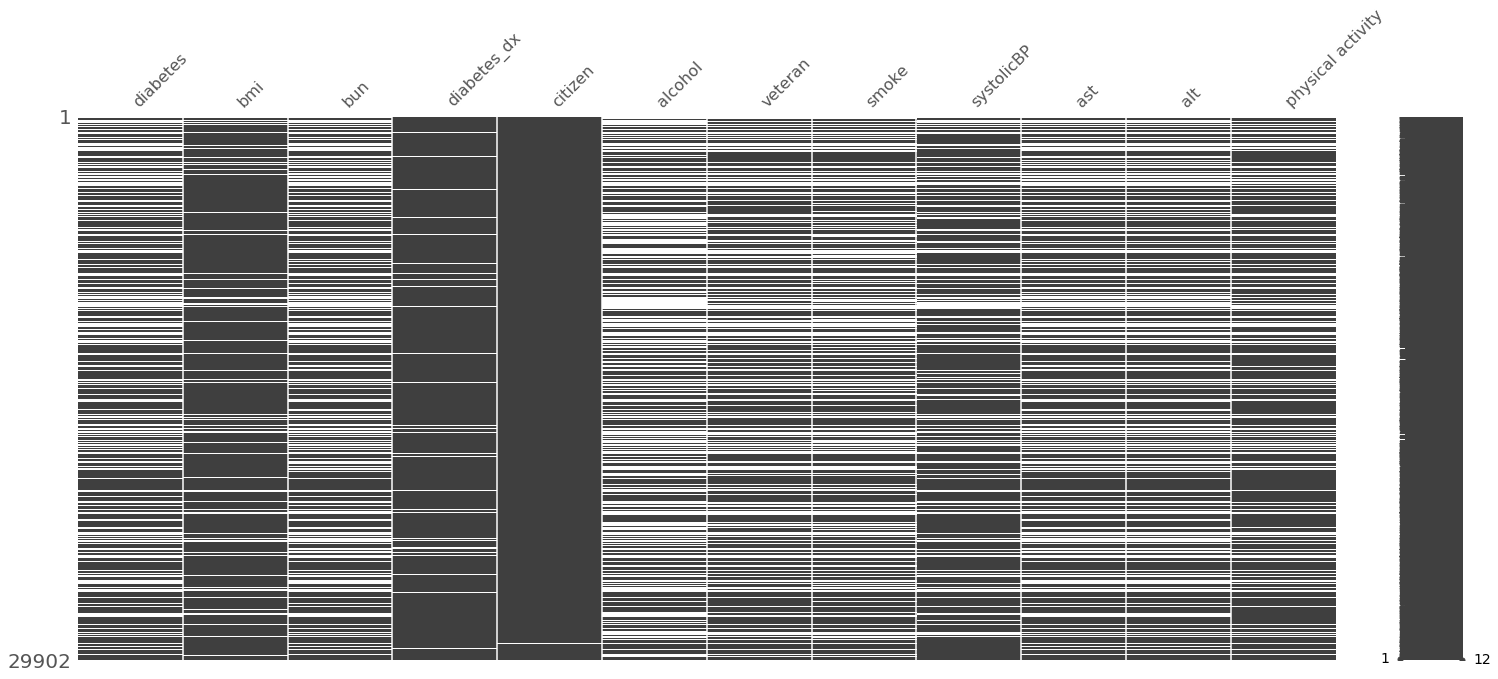

In [12]:
missingdata_df = df.columns[df.isnull().any()].tolist()
# Missing Data Heatmap
msno.matrix(df[missingdata_df])

In [13]:
# KNN Imputation using default K = 5
knn_imputer = KNN()
df_knn = df.copy(deep=True)
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

Imputing row 1/29902 with 0 missing, elapsed time: 243.224
Imputing row 101/29902 with 4 missing, elapsed time: 243.812
Imputing row 201/29902 with 9 missing, elapsed time: 244.087
Imputing row 301/29902 with 0 missing, elapsed time: 244.405
Imputing row 401/29902 with 8 missing, elapsed time: 244.741
Imputing row 501/29902 with 0 missing, elapsed time: 245.156
Imputing row 601/29902 with 0 missing, elapsed time: 245.455
Imputing row 701/29902 with 0 missing, elapsed time: 245.543
Imputing row 801/29902 with 11 missing, elapsed time: 245.638
Imputing row 901/29902 with 1 missing, elapsed time: 245.746
Imputing row 1001/29902 with 1 missing, elapsed time: 245.833
Imputing row 1101/29902 with 0 missing, elapsed time: 245.907
Imputing row 1201/29902 with 0 missing, elapsed time: 245.989
Imputing row 1301/29902 with 0 missing, elapsed time: 246.073
Imputing row 1401/29902 with 7 missing, elapsed time: 246.151
Imputing row 1501/29902 with 0 missing, elapsed time: 246.246
Imputing row 1601/2

Imputing row 13301/29902 with 0 missing, elapsed time: 257.079
Imputing row 13401/29902 with 3 missing, elapsed time: 257.170
Imputing row 13501/29902 with 9 missing, elapsed time: 257.257
Imputing row 13601/29902 with 11 missing, elapsed time: 257.332
Imputing row 13701/29902 with 9 missing, elapsed time: 257.414
Imputing row 13801/29902 with 0 missing, elapsed time: 257.495
Imputing row 13901/29902 with 8 missing, elapsed time: 257.563
Imputing row 14001/29902 with 0 missing, elapsed time: 257.645
Imputing row 14101/29902 with 9 missing, elapsed time: 257.711
Imputing row 14201/29902 with 0 missing, elapsed time: 257.793
Imputing row 14301/29902 with 0 missing, elapsed time: 257.863
Imputing row 14401/29902 with 0 missing, elapsed time: 257.938
Imputing row 14501/29902 with 0 missing, elapsed time: 258.018
Imputing row 14601/29902 with 8 missing, elapsed time: 258.090
Imputing row 14701/29902 with 0 missing, elapsed time: 258.163
Imputing row 14801/29902 with 1 missing, elapsed time:

Imputing row 26401/29902 with 2 missing, elapsed time: 271.430
Imputing row 26501/29902 with 0 missing, elapsed time: 271.525
Imputing row 26601/29902 with 9 missing, elapsed time: 271.600
Imputing row 26701/29902 with 0 missing, elapsed time: 271.750
Imputing row 26801/29902 with 9 missing, elapsed time: 271.902
Imputing row 26901/29902 with 1 missing, elapsed time: 272.018
Imputing row 27001/29902 with 3 missing, elapsed time: 272.122
Imputing row 27101/29902 with 10 missing, elapsed time: 272.186
Imputing row 27201/29902 with 0 missing, elapsed time: 272.245
Imputing row 27301/29902 with 1 missing, elapsed time: 272.305
Imputing row 27401/29902 with 6 missing, elapsed time: 272.372
Imputing row 27501/29902 with 7 missing, elapsed time: 272.454
Imputing row 27601/29902 with 3 missing, elapsed time: 272.517
Imputing row 27701/29902 with 10 missing, elapsed time: 272.577
Imputing row 27801/29902 with 2 missing, elapsed time: 272.644
Imputing row 27901/29902 with 11 missing, elapsed tim

In [14]:
# Multiple Imputation
MICE_imputer = IterativeImputer()
df_MICE = df.copy(deep=True)
df_MICE.iloc[:,:] = MICE_imputer.fit_transform(df_MICE)

In [15]:
df_MICE.describe()

,diabetes,Other Hispanic,NH White,NH Black,Asian,Others,College - Not Graduated or Associates,College degree or Above,age,bmi,...,sex,diabetes_dx,citizen,alcohol,veteran,smoke,systolicBP,ast,alt,physical activity
count,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,...,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000,29902.000000
mean,5.503419,0.111832,0.324828,0.236740,0.113638,0.045549,0.171193,0.142532,31.596014,25.304181,...,0.493311,0.078530,0.894100,0.698303,0.029599,0.378540,115.137542,24.769548,22.516290,0.348849
std,0.911615,0.315165,0.468318,0.425088,0.317376,0.208508,0.376683,0.349601,24.589304,7.615797,...,0.499964,0.268398,0.307131,0.349555,0.240447,0.389789,17.823650,13.195570,16.372022,0.396479
min,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,...,0.000000,-0.111131,0.000000,0.000000,-0.280470,-0.043627,66.000000,7.000000,5.000000,0.000000
25%,5.072833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,19.800000,...,0.000000,0.000000,1.000000,0.581123,-0.001774,0.000000,101.382605,21.000000,16.000000,0.000000
50%,5.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000,24.100000,...,0.000000,0.000000,1.000000,0.820544,0.000000,0.300306,112.000000,23.000000,19.970156,0.306601
75%,5.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,29.644692,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.557924,124.608055,26.000000,24.641469,0.495274
max,17.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,82.900000,...,1.000000,1.311373,1.000000,1.158288,1.000000,1.000000,238.000000,882.000000,1363.000000,1.000000


## Categorize A1c --> Non-Diabetes, Pre-diabetes, Diabetes (Raw and NA Imputed DF)

In [16]:
# 0 = Non, 1 = Pre, 2 = Diabetic

df['diabetes'] = df['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if (x >= 6.5) else x)

df_knn['diabetes'] = df_knn['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df_knn['diabetes'] = df_knn['diabetes'].apply(lambda x: 1 if (x >= 6.5) else x)

df_MICE['diabetes'] = df_MICE['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df_MICE['diabetes'] = df_MICE['diabetes'].apply(lambda x: 1 if (x >= 6.5) else x)


Text(0.5, 0, 'Diabetes')

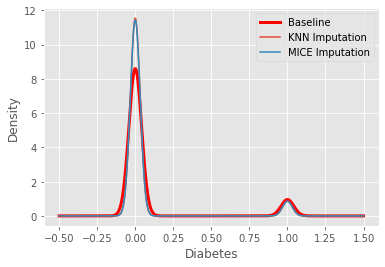

In [17]:
# Plot Diabetes
df['diabetes'].dropna().plot(kind='kde', c='red', linewidth=3)
df_knn['diabetes'].plot(kind='kde')
df_MICE['diabetes'].plot(kind='kde')
labels = ['Baseline', 'KNN Imputation', 'MICE Imputation']
plt.legend(labels)
plt.xlabel('Diabetes')

## Clean up missing values for all predictors

In [18]:
def clean(df):
    df['citizen'] = df['citizen'].apply(lambda x: 0 if x < 0.5 else 1)
    df['diabetes_dx'] = df['diabetes_dx'].apply(lambda x: 0 if x < 0.5 else 1)
    df['alcohol'] = df['alcohol'].apply(lambda x: 0 if x < 0.5 else 1)
    df['veteran'] = df['veteran'].apply(lambda x: 0 if x < 0.5 else 1)
    df['physical activity'] = df['physical activity'].apply(lambda x: 0 if x < 0.5 else 1)
    df['alt'] = df['alt'].apply(lambda x: np.nan if x > 400 else x)
    df['ast'] = df['ast'].apply(lambda x: np.nan if x > 400 else x)
    df['smoke'] = df['smoke'].apply(lambda x: 0 if x < 0.5 else 1)
    return df

df = clean(df)
df_knn = clean(df_knn)
df_MICE = clean(df_MICE)

## Generate Diabetes Status Var

In [19]:
def test_func(df):
    """ Test Function for generating new value"""
    if (df['diabetes'] == 0) & (df['diabetes_dx'] == 0):
        return 0
    elif (df['diabetes'] == 1) & (df['diabetes_dx'] == 0):
        return 1
    elif (df['diabetes'] == 1) & (df['diabetes_dx'] == 1):
        return 2
    else:
        return np.nan

df['diabetes_var'] = df.apply(test_func, axis=1)
df_knn['diabetes_var'] = df_knn.apply(test_func, axis=1)
df_MICE['diabetes_var'] = df_MICE.apply(test_func, axis=1)

In [20]:
df_MICE.diabetes_var.value_counts()

0.0    27123
2.0     1635
1.0      457
Name: diabetes_var, dtype: int64

In [21]:
# Drop lagging NAs
df = df.dropna(axis=0)
df_knn = df_knn.dropna(axis=0)
df_MICE = df_MICE.dropna(axis=0)

# Drop diabetes, diabetes_dx columns
df = df.drop(['diabetes', 'diabetes_dx'], axis=1)
df_knn = df_knn.drop(['diabetes', 'diabetes_dx'], axis=1)
df_MICE = df_MICE.drop(columns=['diabetes', 'diabetes_dx'], axis=1)

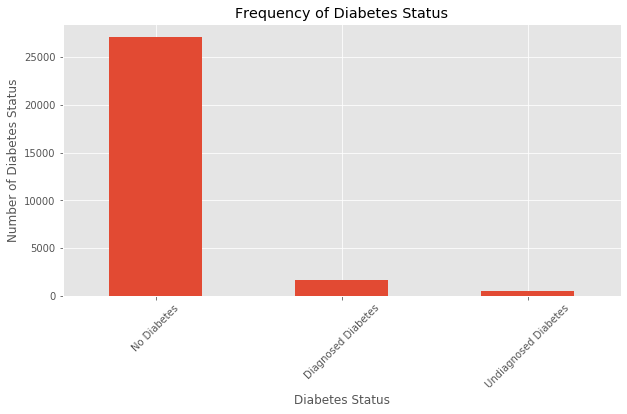

In [22]:
# Barplot for Diabetes Status MICE

df_MICE.diabetes_var.value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))

plt.title('Frequency of Diabetes Status')
plt.xticks(ticks=(0,1,2), labels=('No Diabetes','Diagnosed Diabetes','Undiagnosed Diabetes'), rotation=45)
plt.ylabel('Number of Diabetes Status')
plt.xlabel('Diabetes Status');

,Other Hispanic,NH White,NH Black,Asian,Others,College - Not Graduated or Associates,College degree or Above,age,bmi,bun,sex,citizen,alcohol,veteran,smoke,systolicBP,ast,alt,physical activity
Other Hispanic,1.000000,-0.245906,-0.196994,-0.127287,-0.077843,-0.015997,-0.053025,-0.010172,0.007099,-0.006688,-0.019218,-0.102583,-0.003035,-0.046879,-0.057041,-0.014394,0.004997,0.031958,-0.044320
NH White,-0.245906,1.000000,-0.384955,-0.248738,-0.152117,0.093019,0.099247,0.146257,0.048429,0.141449,0.016490,0.212276,0.114328,0.121268,0.252166,0.042417,0.003696,0.013601,0.160004
NH Black,-0.196994,-0.384955,1.000000,-0.199262,-0.121860,0.019976,-0.070262,-0.033361,0.050480,-0.103691,-0.001322,0.130466,0.023860,0.012690,-0.072559,0.073146,-0.032058,-0.118980,-0.040753
Asian,-0.127287,-0.248738,-0.199262,1.000000,-0.078740,-0.041820,0.179982,0.015979,-0.128868,0.019519,0.003118,-0.213777,-0.274092,-0.068109,-0.099984,-0.024156,0.003580,0.020630,-0.070808
Others,-0.077843,-0.152117,-0.121860,-0.078740,1.000000,-0.002418,-0.030191,-0.086274,-0.043942,-0.055518,0.004987,0.046144,0.055753,-0.002391,0.032522,-0.049694,-0.012772,-0.018765,-0.012117
College - Not Graduated or Associates,-0.015997,0.093019,0.019976,-0.041820,-0.002418,1.000000,-0.183258,0.283028,0.271241,0.119723,-0.046467,0.043346,-0.054547,0.135358,0.155826,0.210312,0.037199,0.080225,0.176341
College degree or Above,-0.053025,0.099247,-0.070262,0.179982,-0.030191,-0.183258,1.000000,0.277479,0.130821,0.156640,-0.010013,-0.041256,-0.047017,0.074138,0.000305,0.132482,0.018505,0.057217,0.040107
age,-0.010172,0.146257,-0.033361,0.015979,-0.086274,0.283028,0.277479,1.000000,0.525459,0.544543,-0.019373,-0.094642,-0.277424,0.298376,0.355969,0.686710,0.091423,0.133176,0.165036
bmi,0.007099,0.048429,0.050480,-0.128868,-0.043942,0.271241,0.130821,0.525459,1.000000,0.269282,-0.065985,-0.054544,-0.176926,0.124401,0.200358,0.485087,0.073707,0.239293,0.211829
bun,-0.006688,0.141449,-0.103691,0.019519,-0.055518,0.119723,0.156640,0.544543,0.269282,1.000000,0.149417,-0.041637,-0.132023,0.203994,0.178180,0.376640,0.041432,0.085422,0.098879


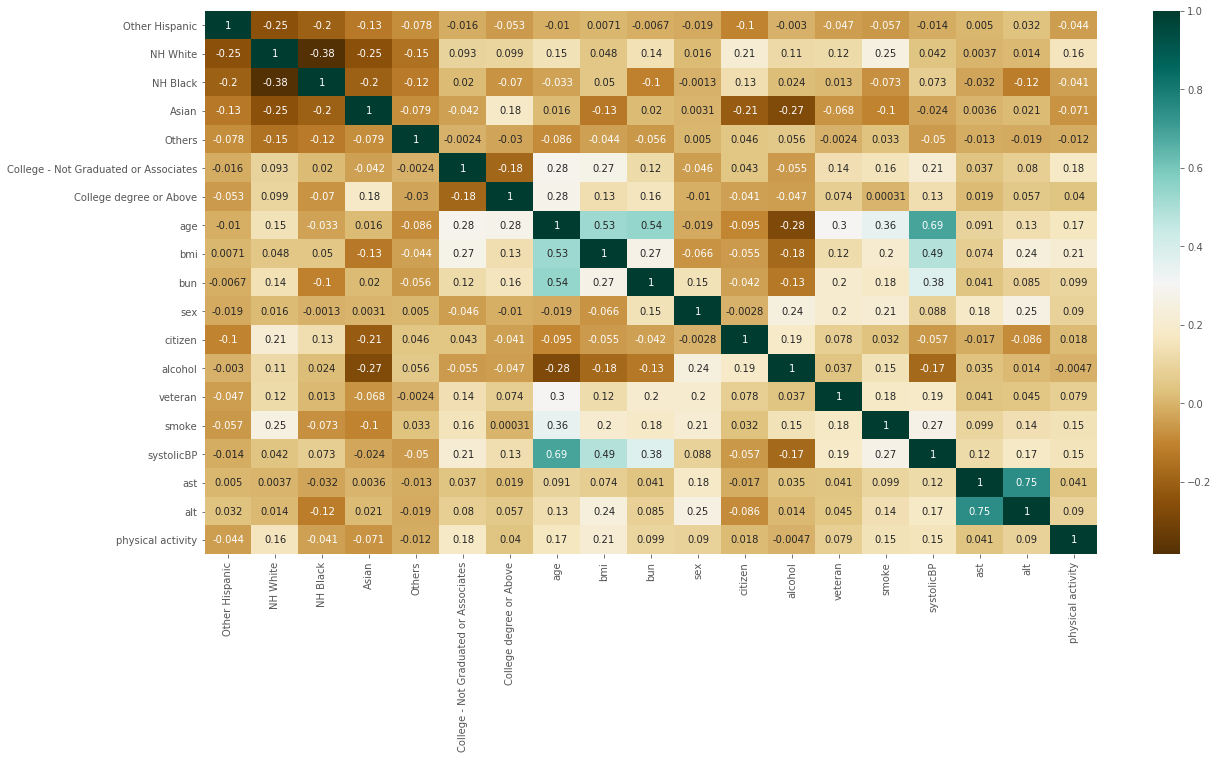

In [23]:
# Heatmap
plt.figure(figsize=(20,10))
c= df_MICE.set_index('diabetes_var').corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

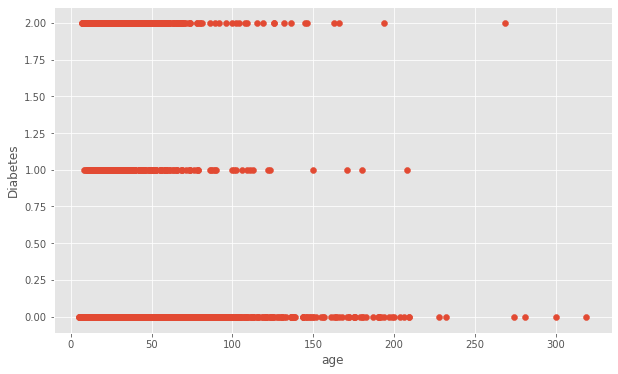

In [24]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df_MICE['alt'], df_MICE['diabetes_var'])
ax.set_xlabel('age')
ax.set_ylabel('Diabetes')
plt.show()

## X_raw and Y_raw

In [25]:
def x_y_raw(df):
    y_raw = df['diabetes_var']
    X_raw = df.drop(['diabetes_var'], axis=1)
    return X_raw, y_raw

In [26]:
X_raw, y_raw = x_y_raw(df_MICE)

## PCA

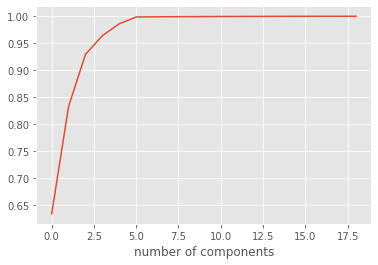

In [27]:
def pca(X_raw, y_raw):
    pca = PCA()
    principalComponents = pca.fit_transform(X_raw)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2',
                                                                     'principal component 3','principal component 4',
                                                                     'principal component 5', 'principal component 6',
                                                                     'principal component 7', 'principal component 8',
                                                                     'principal component 9', 'principal component 10', 
                                                                     'principal component 11', 'principal component 11',
                                                                     'principal component 12', 'principal component 13',
                                                                     'principal component 14', 'principal component 15',
                                                                     'principal component 16', 'principal component 17', 
                                                                     'principal component 18'
                                                                     ])
    eig_values = pca.explained_variance_
    eig_vectors = pca.components_
    pc1 = pca.components_[0]
    pc2 = pca.components_[1]
    structure_loading_1 = pc1* np.sqrt(eig_values[0])
    str_loading_1 = pd.Series(structure_loading_1, index=X_raw.columns)
    str_loading_1.sort_values(ascending = False)
    
#     index = np.arange(19)
#     plt.bar(index, pca.explained_variance_ratio_)
#     plt.title('Scree plot for PCA')
#     plt.xticks(ticks=(np.arange(19)))
#     plt.xlabel('Num of components')
#     plt.ylabel('proportion of explained variance')
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
#     plt.ylabel('explained variance ratio')


pca(X_raw, y_raw)

In [28]:
# X_raw = df_MICE.drop(['Asian', 'NH Black', 'Other Hispanic', 'Others', 'citizen', 'alcohol'], axis=1)
# X_raw = df_MICE.drop('age', axis=1)

## Train Test Split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=123)

## Standardize

In [30]:
from sklearn.preprocessing import StandardScaler

def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [31]:
X_train_base, X_test_base = standardize(X_train_base, X_test_base)
X_train_knn, X_test_knn = standardize(X_train_knn, X_test_knn)
X_train, X_test = standardize(X_train, X_test)

NameError: name 'X_train_base' is not defined

## SMOTE

In [32]:
def smote(X_train, y_train):

    print('Original dataset shape %s' % Counter(y_train))

    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))
    return X_train, y_train


In [33]:
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0.0: 19013, 2.0: 1119, 1.0: 315})
Resampled dataset shape Counter({0.0: 19013, 2.0: 19013, 1.0: 19013})


## Logistic Regression

In [34]:
def logistic(X_train, X_test, y_train, y_test):
    
    logreg = LogisticRegression(solver='sag')
    logreg.fit(X_train, y_train)
    
    dictionary = dict(zip(list(X_raw.columns), list(logreg.coef_[0])))
    print(dictionary)
    
    print(f'logistic train score: {logreg.score(X_train, y_train)}')
    print(f'logistic test score: {logreg.score(X_test, y_test)}')
    y_pred = logreg.predict(X_test)
    
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, y_pred)
    print(classification_report(y_test, y_pred))

    return cm, classes, logreg, cr
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Logistic Regression',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix - Logistic Regression')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


{'Other Hispanic': 0.18633792650457234, 'NH White': 0.30723162874554916, 'NH Black': -0.14918160712599357, 'Asian': 0.23095652135122388, 'Others': 0.08032131615076527, 'College - Not Graduated or Associates': -0.06714980995278581, 'College degree or Above': 0.3551486323453118, 'age': -0.05317021241259696, 'bmi': -0.050485188205369465, 'bun': 0.025904836091925808, 'sex': -0.36336837453968723, 'citizen': 0.7855553767398501, 'alcohol': 0.8111094034267057, 'veteran': 0.6399408695195264, 'smoke': 0.4236384764473995, 'systolicBP': 0.00983019746032607, 'ast': 0.027100034938750638, 'alt': -0.02788811475579235, 'physical activity': 0.8128726213221165}
logistic train score: 0.6749417065516576
logistic test score: 0.7622090369694203
              precision    recall  f1-score   support

         0.0       0.98      0.79      0.87      8107
         1.0       0.06      0.44      0.11       142
         2.0       0.20      0.48      0.28       515

    accuracy                           0.76      8

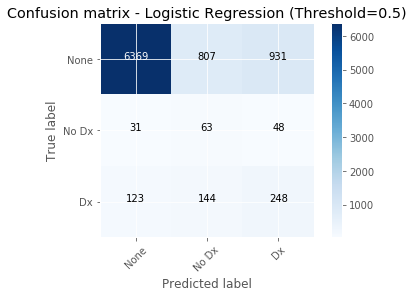

In [35]:
cm, classes, logreg, cr = logistic(X_train, X_test, y_train, y_test)

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Logistic Regression (Threshold=0.5)',
                          cmap=plt.cm.Blues)

## Threshold

In [ ]:
threshold = 0.5

preds = np.where(logreg.predict_proba(X_test)[:,1] > threshold, 1, 0)
df_threshold = pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                   metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
threshold = 0.75

preds = np.where(logreg.predict_proba(X_test)[:,1] > threshold, 1, 0)
df_threshold['0.75'] = pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                   metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
threshold = 0.25

preds = np.where(logreg.predict_proba(X_test)[:,1] > threshold, 1, 0)
df_threshold['0.3'] = pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                   metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
             index=["accuracy", "recall", "precision", "F1"])

In [ ]:
df_threshold.columns = ['0.5', '0.75', '0.25']
df_threshold.head()

In [ ]:
y_pred_prob_0 = logreg.predict_proba(X_test)[:, 0]
y_pred_prob_1 = logreg.predict_proba(X_test)[:, 1]
y_pred_prob_2 = logreg.predict_proba(X_test)[:, 2]


# histogram of predicted probabilities
plt.hist(y_pred_prob_0, bins=8, alpha=0.25, label='No Diabetes')
plt.hist(y_pred_prob_1, bins=8, alpha=0.5, label='Dx')
plt.hist(y_pred_prob_2, bins=8, alpha=0.5, label='Undx')

plt.xlim(0, 1)
plt.ylim(0, 6000)
plt.title('Histogram of predicted probabilities')
plt.legend(loc=1)
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency');

In [ ]:
# predict diabetes if the predicted probability is greater than 0.25
from sklearn.preprocessing import binarize
y_pred_class_1 = binarize([y_pred_prob_1], 0.25)[0]
print(cm)
print('\n')
print(metrics.confusion_matrix(y_test, y_pred_class_1))

In [ ]:
cm_1 = confusion_matrix(y_test, y_pred_class_1)
plot_confusion_matrix(cm_1, classes,
                          normalize=False,
                          title='Confusion matrix - Logistic Regression (Threshold 0.25)',
                          cmap=plt.cm.Blues)

## Decision Tree

In [ ]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_raw.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

def tree(X_train, X_test, y_train, y_test):
    
    tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5) 
    tree_clf.fit(X_train, y_train)
    
    print(f'decision train score: {tree_clf.score(X_train, y_train)}')
    print(f'decision test score: {tree_clf.score(X_test, y_test)}')
    
    print(plot_feature_importances(tree_clf.fit(X_train, y_train)))
    pred = tree_clf.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
#     classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, tree_clf, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, tree_clf, cr = tree(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Decision Tree (Threshold = 0.5)',
                          cmap=plt.cm.Blues)

plot_feature_importances(tree_clf)

## Threshold

In [ ]:
def threshold(threshold_list, model):
    df_threshold = pd.DataFrame([])
    for i in threshold_list:
        preds = np.where(model.predict_proba(X_test)[:,1] > i, 1, 0)
        df_threshold[i] = pd.Series(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                           metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
                     index=["accuracy", "recall", "precision", "F1"])
    return df_threshold

threshold_list = [0.25,0.5,0.75]
threshold(threshold_list, tree_clf)

def plot_predict_proba(X_test, model):
    y_pred_prob_0 = model.predict_proba(X_test)[:, 0]
    y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
    y_pred_prob_2 = model.predict_proba(X_test)[:, 2]
    
    # histogram of predicted probabilities
    for i in threshold_list:
        plt.hist(y_pred_prob_0, bins=8, alpha=i, label='No Diabetes')
        plt.hist(y_pred_prob_1, bins=8, alpha=i, label='Dx')
        plt.hist(y_pred_prob_2, bins=8, alpha=i, label='UnDx')
    plt.xlim(0, 1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of diabetes')
    plt.ylabel('Frequency');
    return y_pred_prob_1

# y_pred_prob_1 = plot_predict_proba(X_test, tree_clf)

def c_matrices(cm, y_test, y_pred_prob_1):
    # predict diabetes if the predicted probability is greater than 0.25
    y_pred_class_1 = binarize([y_pred_prob_1], 0.25)[0]
    print(cm)
    print('\n')
    print(metrics.confusion_matrix(y_test, y_pred_class_1))
    
    cm_1 = confusion_matrix(y_test, y_pred_class_1)
#     classes = ['None', 'No Dx', 'Dx']
    plot_confusion_matrix(cm_1, classes,
                              normalize=False,
                              title='Confusion matrix - Logistic Regression (Threshold 0.25)',
                              cmap=plt.cm.Blues)
c_matrices(cm, y_test, y_pred_prob_1)

In [ ]:
def plot_predict_proba(X_test, model):
    y_pred_prob_0 = model.predict_proba(X_test)[:, 0]
    y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
    y_pred_prob_2 = model.predict_proba(X_test)[:, 2]
    
    # histogram of predicted probabilities
    plt.hist(y_pred_prob_0, bins=8, alpha=.5, label='No Diabetes')
    plt.hist(y_pred_prob_1, bins=8, alpha=.5, label='Dx')
    plt.hist(y_pred_prob_2, bins=8, alpha=.5, label='UnDx')
    plt.xlim(0, 1)
    plt.ylim(0, 8000)
    plt.legend(loc=1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of diabetes')
    plt.ylabel('Frequency');
    return y_pred_prob_1

y_pred_prob_1 = plot_predict_proba(X_test, tree_clf)

In [ ]:
def c_matrices(cm, y_test, y_pred_prob_1):
    # predict diabetes if the predicted probability is greater than 0.25
    y_pred_class_1 = binarize([y_pred_prob_1], 0.25)[0]
    print(cm)
    print('\n')
    print(metrics.confusion_matrix(y_test, y_pred_class_1))
    
    cm_1 = confusion_matrix(y_test, y_pred_class_1)
#     classes = ['None', 'No Dx', 'Dx']
    plot_confusion_matrix(cm_1, classes,
                              normalize=False,
                              title='Confusion matrix - Decision Tree (Threshold = 0.25)',
                              cmap=plt.cm.Blues)
c_matrices(cm, y_test, y_pred_prob_1)

## CV Decision Tree

In [ ]:
def tree_cv(X_train, X_test, y_train, y_test):
    dt_param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 3, 4, 5, 6]
    }

    # Instantiate GridSearchCV
    dt_grid_search = GridSearchCV(tree_clf, dt_param_grid, cv=3, return_train_score=True)

    # Fit to the data
    dt_grid_search.fit(X_train, y_train)

    # Mean training score
    dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

    # Mean test score
    dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

    print(f"Mean Training Score: {dt_gs_training_score :.2%}")
    print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
    print("Best Parameter Combination Found During Grid Search:")
    dt_grid_search.best_params_
    
    pred = dt_grid_search.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, tree_cv, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, tree_cv, cr = tree_cv(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Decision Tree Tuned',
                          cmap=plt.cm.Blues)

## Bagged Trees

In [ ]:
def bagged_tree(X_train, X_test, y_train, y_test):
    
    bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)
    bagged_tree.fit(X_train, y_train)
    print(f'bagged train score: {bagged_tree.score(X_train, y_train)}')
    print(f'bagged test score: {bagged_tree.score(X_test, y_test)}')
    
    pred = bagged_tree.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
    classes = ['None', 'Dx', 'No Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, bagged_tree, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, bagged_tree, cr = bagged_tree(X_train, X_test, y_train, y_test)

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Bagged Trees (Threshold = 0.5)',
                          cmap=plt.cm.Blues)

In [ ]:
def threshold(threshold_list, model):
    df_threshold = pd.DataFrame([])
    for i in threshold_list:
        preds = np.where(model.predict_proba(X_test)[:,1] > i, 1, 0)
        df_threshold[i] = pd.Series(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                           metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
                     index=["accuracy", "recall", "precision", "F1"])
    return df_threshold

threshold_list = [0.25,0.5,0.75]
threshold = threshold(threshold_list, bagged_tree)


# y_pred_prob_1 = plot_predict_proba(X_test, bagged_tree)

def c_matrices(cm, y_test, y_pred_prob_1):
    # predict diabetes if the predicted probability is greater than 0.25
    y_pred_class_1 = binarize([y_pred_prob_1], 0.25)[0]
    print(cm)
    print('\n')
    print(metrics.confusion_matrix(y_test, y_pred_class_1))
    
    cm_1 = confusion_matrix(y_test, y_pred_class_1)
    classes = ['None', 'No Dx', 'Dx']
    plot_confusion_matrix(cm_1, classes,
                              normalize=False,
                              title='Confusion matrix - Bagged Trees (Threshold 0.25)',
                              cmap=plt.cm.Blues)
    
c_matrices(cm, y_test, y_pred_prob_1)

In [ ]:
def plot_predict_proba(X_test, model):
    y_pred_prob_0 = model.predict_proba(X_test)[:, 0]
    y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
    y_pred_prob_2 = model.predict_proba(X_test)[:, 2]
    
    # histogram of predicted probabilities
    plt.hist(y_pred_prob_0, bins=8, alpha=0.5, label='No Diabetes')
    plt.hist(y_pred_prob_1, bins=8, alpha=0.5, label='Dx')
    plt.hist(y_pred_prob_2, bins=8, alpha=0.5, label='NoDx')
    plt.xlim(0, 1)
    plt.ylim(0,8000)
    plt.legend(loc=1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of diabetes')
    plt.ylabel('Frequency');
    return y_pred_prob_1

plot_predict_proba(X_test, bagged_tree)

## Random Forest

In [ ]:
def random_forest(X_train, X_test, y_train, y_test):
    
    forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
    mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))

    print(f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}")

    forest.fit(X_train, y_train)

    print(f'train: {forest.score(X_train, y_train)}')
    print(f'test: {forest.score(X_test, y_test)}')

    pred = forest.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, forest, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, forest, cr = random_forest(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Random Forest (Threshold = 0.5)',
                          cmap=plt.cm.Blues)


In [ ]:
# TREE PLOT

estimator = forest.estimators_[0]
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_raw.columns,
                class_names = y_raw.name,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

## WHY PREDICTING 20 FEAUTRES?

In [ ]:
def threshold(threshold_list, model):
    df_threshold = pd.DataFrame([])
    for i in threshold_list:
        preds = np.where(model.predict_proba(X_test)[:,1] > i, 1, 0)
        df_threshold[i] = pd.Series(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                           metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
                     index=["accuracy", "recall", "precision", "F1"])
    return df_threshold

threshold_list = [0.25,0.5,0.75]
threshold = threshold(threshold_list, forest)

def plot_predict_proba(X_test, model):
    y_pred_prob_0 = model.predict_proba(X_test)[:, 0]
    y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
    y_pred_prob_2 = model.predict_proba(X_test)[:, 2]
    
    # histogram of predicted probabilities
    plt.hist(y_pred_prob_0, bins=8, alpha=0.5, label='No Diabetes')
    plt.hist(y_pred_prob_1, bins=8, alpha=0.5, label='Dx')
    plt.hist(y_pred_prob_2, bins=8, alpha=0.5, label='UnDx')
    plt.xlim(0, 1) #1
    plt.ylim(0,6000)
    plt.legend(loc=1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of diabetes')
    plt.ylabel('Frequency');
    return y_pred_prob_1

# y_pred_prob_1 = plot_predict_proba(X_test, forest)

def c_matrices(cm, y_test, y_pred_prob_1):
    # predict diabetes if the predicted probability is greater than 0.25
    y_pred_class_1 = binarize([y_pred_prob_1], 0.25)[0]
    print(cm)
    print('\n')
    print(metrics.confusion_matrix(y_test, y_pred_class_1))
    
    cm_1 = confusion_matrix(y_test, y_pred_class_1)
#     classes = ['None', 'No Dx', 'Dx']
    plot_confusion_matrix(cm_1, classes,
                              normalize=False,
                              title='Confusion matrix - Random Forest (Threshold = 0.25)',
                              cmap=plt.cm.Blues)
    
c_matrices(cm, y_test, y_pred_prob_1)


## RF Tuned

In [ ]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)

rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(forest, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters:  {rf_grid_search.best_params_}")

In [ ]:
rf_grid_search.best_params_

In [ ]:
print(rf_grid_search.score(X_train, y_train))
print(rf_grid_search.score(X_test, y_test))
pred = rf_grid_search.predict(X_test)
cm = confusion_matrix(y_test, pred)
# classes = ['None', 'Dx', 'No Dx']
cr = classification_report(y_test, pred)
print(classification_report(y_test, pred))

plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Random Forest Tuned',
                          cmap=plt.cm.Blues)

In [ ]:
def threshold(threshold_list, model):
    df_threshold = pd.DataFrame([])
    for i in threshold_list:
        preds = np.where(model.predict_proba(X_test)[:,1] > i, 1, 0)
        df_threshold[i] = pd.Series(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds, average='macro'),
                           metrics.precision_score(y_test, preds, average='macro'), metrics.f1_score(y_test, preds, average='macro')], 
                     index=["accuracy", "recall", "precision", "F1"])
    return df_threshold

threshold_list = [0.25,0.5,0.75]
threshold = threshold(threshold_list, rf_grid_search)
threshold

In [ ]:
def plot_predict_proba(X_test, model):
    y_pred_prob_0 = model.predict_proba(X_test)[:, 0]
    y_pred_prob_1 = model.predict_proba(X_test)[:, 1]
    y_pred_prob_2 = model.predict_proba(X_test)[:, 2]
    
    # histogram of predicted probabilities
    plt.hist(y_pred_prob_0, bins=8, alpha=0.5, label='No Diabetes')
    plt.hist(y_pred_prob_1, bins=8, alpha=0.5, label='Dx')
    plt.hist(y_pred_prob_2, bins=8, alpha=0.5, label='UnDx')
    plt.xlim(0, 1) #1
    plt.ylim(0,6000)
    plt.legend(loc=1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of diabetes')
    plt.ylabel('Frequency');
    return y_pred_prob_1

plot_predict_proba(X_test, rf_grid_search)

## Adaboost and GradientBoostClassifier

In [ ]:
def adaboost(X_train, X_test, y_train, y_test):
    
    adaboost_clf = AdaBoostClassifier(random_state=42)
    adaboost_clf.fit(X_train, y_train)

    print(f'train: {adaboost_clf.score(X_train, y_train)}')
    print(f'test: {adaboost_clf.score(X_test, y_test)}')

    pred = adaboost_clf.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
#     classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, adaboost, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, adaboost, cr = adaboost(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Adaboost',
                          cmap=plt.cm.Blues)

In [ ]:
def gb(X_train, X_test, y_train, y_test):
    
    gb_clf = GradientBoostingClassifier(random_state=42)
    gb_clf.fit(X_train, y_train)

    print(f'train: {gb_clf.score(X_train, y_train)}')
    print(f'test: {gb_clf.score(X_test, y_test)}')

    pred = gb_clf.predict(X_test)
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
#     classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, gb_clf, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, gb_clf, cr = gb(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - Gradient Boost',
                          cmap=plt.cm.Blues)

## XGboost

In [ ]:
def xgb(X_train, X_test, y_train, y_test):
    
    #  Instantiate XGBClassifier
    xgb.clf = XGBClassifier()
    xgb.clf.fit(X_train, y_train)

    print(f'train: {xgb.clf.score(X_train, y_train)}')
    print(f'test: {xgb.clf.score(X_test, y_test)}')

    training_preds = xgb.clf.predict(X_train)
    pred = xgb.clf.predict(X_test)

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
#     classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, xgb, cr

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm, classes, xgb, cr = xgb(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - XGboost',
                          cmap=plt.cm.Blues)

In [ ]:
def xgb_cv(X_train, X_test, y_train, y_test):
    
    param_grid = {
    'learning_rate': [0.1, 0.2, 0.5],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
    }

    xgb.clf = XGBClassifier()    
    grid_clf = GridSearchCV(xgb.clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
    grid_clf.fit(X_train, y_train)

    best_parameters = grid_clf.best_params_

    print('Grid Search found the following optimal parameters: ')
    for param_name in sorted(best_parameters.keys()):
        print('%s: %r' % (param_name, best_parameters[param_name]))

    training_preds = grid_clf.predict(X_train)
    test_preds = grid_clf.predict(X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    test_accuracy = accuracy_score(y_test, test_preds)

    print('')
    print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
    print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
#     classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))

    return cm, classes, xgb_cv, cr


In [ ]:
xgb_cv(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - XG Boost Tuned',
                          cmap=plt.cm.Blues)

## SVM

In [ ]:
def svm(X_train, X_test, y_train, y_test):
    
    svclassifier = SVC(kernel='rbf', C=1000)  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)        
    print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))
    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, pred)
    classes = ['None', 'No Dx', 'Dx']
    cr = classification_report(y_test, pred)
    print(classification_report(y_test, pred))
    return cm, classes, svm, cr


In [ ]:
cm, classes, svm, cr = svm(X_train, X_test, y_train, y_test)
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix - SVM',
                          cmap=plt.cm.Blues)